### Libs

In [84]:
import requests
import json
import numpy as np
import pandas as pd
from random import uniform
from IPython.display import clear_output
import time
import matplotlib.pyplot as plt
import folium

### General Class

In [85]:
class DistanceTable:
    def __init__(self, raw_data):
        self.raw_data = raw_data
    
    def get_coordinates(self):
        coordinates = []
        coordinates.append(self.raw_data['origin'])
        for delivery in self.raw_data['deliveries']:
            coordinates.append(delivery['point'])
        return coordinates
    
    def calc_distances(self, coordinates):
        n_coordinates = len(coordinates)
        distances = np.zeros((n_coordinates, n_coordinates))
        for i in range(n_coordinates):
            for j in range(n_coordinates):
                if i != j:
                    origin = f"{coordinates[i]['lng']},{coordinates[i]['lat']}"
                    destination = f"{coordinates[j]['lng']},{coordinates[j]['lat']}"
                    route_str = ";".join([origin, destination])
                    query = f"https://router.project-osrm.org/route/v1/driving/{route_str}?overview=false"
                    response = requests.get(query)
                    data = response.json()
                    distances[i][j] = data["routes"][0]["distance"]
        return distances
    
    def calc_distances_matrix(self):
        points = self.get_coordinates()
        distances = self.calc_distances(points)
        df = pd.DataFrame(distances)
        df.to_csv('dataset\distances_matrix.csv', index=False)
    
    def read_csv(self):
        return pd.read_csv('dataset\distances_matrix.csv')

In [86]:
class Delivery:
    def __init__(self, raw_delivery, index):
        self.id = raw_delivery["id"]
        self.size = raw_delivery["size"]

In [87]:
class DepotNet:
    def __init__(self, raw_data):
        self.vehicle_capacity = raw_data["vehicle_capacity"]
        self.deliveries = [Delivery(raw_data["deliveries"][i], i) for i in range(len(raw_data["deliveries"]))]

### Data

In [88]:
with open('dataset\cvrp_castanhal.json') as json_file:
    raw_data = json.load(json_file)
    for i in range(len(raw_data["deliveries"])):
        raw_data["deliveries"][i]["id"] = i + 1

dt = DistanceTable(raw_data)
#dt.calc_distances_matrix()
distances_matrix = dt.read_csv()

### Genetic Algorithm

In [89]:
class GA:
    def __init__(self, distances_matrix, depot_net, max_gerations, k, mutation_rate):
        self.distances_matrix = distances_matrix
        self.depot_net = depot_net
        self.max_gerations = max_gerations
        self.k = k
        self.mutation_rate = mutation_rate
        self.population = []
        self.best_solution = []
        self.best_solutions = pd.DataFrame(columns=[f"x_{i}" for i in range(len(self.depot_net.deliveries))]+["y"])
        self.run()

    def generate_solution(self):
        n = len(self.depot_net.deliveries)
        solution = np.random.choice([i for i in range(n)], n, replace=False)
        return [self.depot_net.deliveries[idx].id for idx in solution]
    
    def generate_population(self, k):
        return [self.generate_solution() for _ in range(k)]
    
    def fitness(self, solution):
        route_list = [0]
        weight = 0
        for delivery in [self.depot_net.deliveries[idx-1] for idx in solution]:
            #Considerando que cada uma das entregas possui peso menor que a capacidade máxima do carro
            if (weight + delivery.size) <= self.depot_net.vehicle_capacity:
                weight += delivery.size
                route_list.append(delivery.id)
            else:
                route_list.append(0)
                weight = delivery.size
                route_list.append(delivery.id)
        route_list.append(0)
        costs = [self.distances_matrix.iloc[route_list[i],route_list[i+1]] for i in range(len(route_list)-1)] 
        return sum(costs)
    
    def select_parents(self):
        sum_fitnesses = sum([self.fitness(solution) for solution in self.population])
        probability_distribution = [self.fitness(solution) / sum_fitnesses for solution in self.population]
        # 2 indexes among k individuals are chosen, without repetition, accordingly with probability distribution
        parents_index = np.random.choice(len(self.population), 2, p=probability_distribution, replace=False)
        return [self.population[i] for i in parents_index]

    def crossover(self, parents):
        #LOX
        parent1, parent2 = parents[0], parents[1]
        child1 = np.zeros(len(parent1), dtype=int)
        child2 = np.zeros(len(parent1), dtype=int)
        dist = 0
        while dist < 1:
            points = np.random.randint(0, len(parent1)-1, 2)
            dist = abs(points[0]-points[1])
            if dist > 0:
                points = np.sort(points)
        for i in range(points[0], points[1]+1):
            child1[i], child2[i] = parent1[i], parent2[i]
        for i in range(len(parent2)):
            if parent2[i] not in child1:
                for j in range(len(child1)):
                    if child1[j] == 0:
                        child1[j] = parent2[i]
                        break
        for i in range(len(parent1)):
            if parent1[i] not in child2:
                for j in range(len(child2)):
                    if child2[j] == 0:
                        child2[j] = parent1[i]
                        break
        return [child1, child2]
    
    def mutate(self, child):
        if uniform(0, 1) <= self.mutation_rate:
            indexes = [i for i in range(0, len(child))]
            permute = np.random.choice(indexes, 2, replace=False)
            child[permute[0]], child[permute[1]] = child[permute[1]], child[permute[0]]
        return child

    def select_survivors(self, mutated_children):
        for child in mutated_children:
            self.population.append(child)

        candidates = sorted(self.population, key=lambda x: self.fitness(x), reverse=False)
        self.population = []

        for i in range(0, round(self.k/2)):
            self.population.append(candidates[i])

        while len(self.population) < self.k:
            self.population.append(self.generate_solution())

    def compute_gbest(self):
        candidates = sorted(self.population, key=lambda x: self.fitness(x), reverse=False)
        self.best_solution = candidates[0]
        s = pd.Series([self.depot_net.deliveries[idx-1].id for idx in candidates[0]]+[self.fitness(candidates[0])],index=[f"x_{i}" for i in range(len(candidates[0]))]+["y"])
        self.best_solutions = self.best_solutions.append(s, ignore_index=True)
        df = self.best_solutions.iloc[:, :-1].astype(int)
        df["y"] = self.best_solutions["y"]
        self.best_solutions = df

    def run(self):
        self.population = self.generate_population(self.k)
        candidates = sorted(self.population, key=lambda x: self.fitness(x), reverse=False)
        self.best_solution = candidates[0]
        for g in range(self.max_gerations):
            self.progress_bar(g+1)
            parents = self.select_parents()
            children = self.crossover(parents)
            mutated_children = [self.mutate(child) for child in children]
            self.select_survivors(mutated_children)
            self.compute_gbest()
        #limpar a tela
        clear_output(wait=True)

    def progress_bar(self, i):
        #clear_output(wait=True)
        pc = int(i/self.max_gerations*100)
        logic_char = 0 if i == 1 else int(pc/2)
        print(f"Executando geração {i}/{self.max_gerations}:|{'█' * logic_char + '.' * (50 - logic_char)}|{pc}%",
              end='\r', flush=True)

### Run

In [90]:
depot_net = DepotNet(raw_data)
max_gerations = 1000
k = 100
mutation_rate = 0.05
max_executions = 10
ga_search_list = []

start_time = time.time()

for i in range(max_executions):
    print(f'Execução {i+1}/{max_executions}')
    ga_search_list.append(GA(distances_matrix, depot_net, max_gerations, k, mutation_rate))

end_time = time.time()

hours = int((end_time - start_time)/3600)
minutes = int((end_time - start_time)/60) - hours*60
seconds = int((end_time - start_time)) - minutes*60 - hours*3600
print(f'Tempo de execução: {hours}h {minutes}m {seconds}s')

Tempo de execução: 2h 13m 43s


### Analysis

In [91]:
#verificar melhor execução
best_solution = ga_search_list[0].best_solution
best_cost = ga_search_list[0].fitness(best_solution)
best_ga = ga_search_list[0]
df_exe_ga = pd.DataFrame(columns=['Solution', 'Cost'])
df_best_ga = pd.DataFrame(columns=[f"x_{i}" for i in range(len(raw_data['deliveries']))]+["y"])        

for ga in ga_search_list:
    cost = ga.fitness(ga.best_solution)
    df_exe_ga.loc[len(df_exe_ga)] = [ga.best_solution, cost]
    
    if cost < best_cost:
        best_solution = ga.best_solution
        best_cost = cost
        best_ga = ga

df_best_ga = best_ga.best_solutions.copy()
df_best_ga.to_csv('results/best_solutions_ga.csv', index=False)
df_exe_ga.to_csv('results/exe_ga.csv', index=False)

##### Average Result

In [92]:
df_average = pd.DataFrame([df_exe_ga['Cost'].mean(),df_exe_ga['Cost'].std()],index=['mean','std']).T

df_average

,mean,std
0,160698.28,4530.686536


##### Best solutions (Best execution)

In [93]:
print(f'Melhores soluções globais por iteração:')
display(best_ga.best_solutions)
index_best_solutions = best_ga.best_solutions.loc[best_ga.best_solutions["y"] == best_ga.best_solutions["y"].min()].index
print(f'Melhor(res) solução(ões) apresentada(s) no(s) índece(s):\n{index_best_solutions.astype(int).tolist()}')

Melhores soluções globais por iteração:


,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,...,x_26,x_27,x_28,x_29,x_30,x_31,x_32,x_33,x_34,y
0,14,30,35,9,33,18,16,15,34,26,...,8,27,20,24,11,28,23,25,1,302862.8
1,14,30,35,9,33,18,16,15,34,26,...,8,27,20,24,11,28,23,25,1,302862.8
2,14,30,35,9,33,18,16,15,34,26,...,8,27,20,24,11,28,23,25,1,302862.8
3,14,30,35,9,33,18,16,15,34,26,...,8,27,20,24,11,28,23,25,1,302862.8
4,14,30,35,9,33,18,16,15,34,26,...,8,27,20,24,11,28,23,25,1,302862.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,32,4,5,3,1,6,2,23,29,27,...,11,20,33,18,12,14,35,31,34,153381.6
996,32,4,5,3,1,6,2,23,29,27,...,11,20,33,18,12,14,35,31,34,153381.6
997,32,4,5,3,1,6,2,23,29,27,...,11,20,33,18,12,14,35,31,34,153381.6
998,32,4,5,3,1,6,2,23,29,27,...,11,20,33,18,12,14,35,31,34,153381.6


Melhor(res) solução(ões) apresentada(s) no(s) índece(s):
[844, 845, 846, 847, 848, 849, 850, 851, 852, 853, 854, 855, 856, 857, 858, 859, 860, 861, 862, 863, 864, 865, 866, 867, 868, 869, 870, 871, 872, 873, 874, 875, 876, 877, 878, 879, 880, 881, 882, 883, 884, 885, 886, 887, 888, 889, 890, 891, 892, 893, 894, 895, 896, 897, 898, 899, 900, 901, 902, 903, 904, 905, 906, 907, 908, 909, 910, 911, 912, 913, 914, 915, 916, 917, 918, 919, 920, 921, 922, 923, 924, 925, 926, 927, 928, 929, 930, 931, 932, 933, 934, 935, 936, 937, 938, 939, 940, 941, 942, 943, 944, 945, 946, 947, 948, 949, 950, 951, 952, 953, 954, 955, 956, 957, 958, 959, 960, 961, 962, 963, 964, 965, 966, 967, 968, 969, 970, 971, 972, 973, 974, 975, 976, 977, 978, 979, 980, 981, 982, 983, 984, 985, 986, 987, 988, 989, 990, 991, 992, 993, 994, 995, 996, 997, 998, 999]


##### Graphic convergence (Best execution)

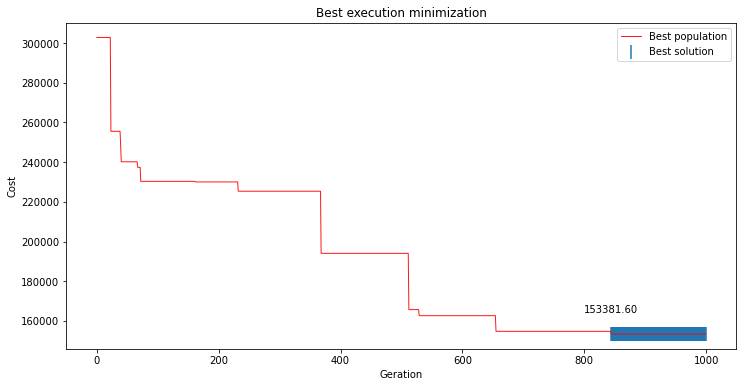

In [94]:
#Convergência na melhor execução
x = np.arange(0, max_gerations, 1)
y = best_ga.best_solutions["y"].values
#yerr = df_average["std"].values

fig, ax = plt.subplots()
fig.set_size_inches(12,6)
lines = ax.plot(x, y, color='red', lw=1, alpha=0.9)
#ax.fill_between(x, y-yerr, y+yerr, color='red', alpha=0.2,  linewidth=0.0)
ax.set_title('Best execution minimization')
ax.set_xlabel('Geration')
ax.set_ylabel('Cost')
best = best_ga.best_solutions.loc[best_ga.best_solutions["y"] == best_ga.best_solutions["y"].min()]["y"].values
index_min = best_ga.best_solutions.loc[best_ga.best_solutions["y"] == best_ga.best_solutions["y"].min()].index
ax.scatter(index_min, best, marker='|', s=200)
ax.annotate(f'{best[0]:.2f}', (index_min[0], best[0]), xytext=(index_min[0], best[0]+10000), ha='center', va='bottom')
ax.legend(['Best population', 'Best solution'])
plt.savefig('results/graphic_convergence_best', dpi = 300)
plt.show()

##### Response request OSRM

In [95]:
#Pegando dados da melhor solução
best_solution = [int(x) for x in best_ga.best_solutions.iloc[-1][:-1].to_list()]
deliveries = raw_data['deliveries']

routes = []
route_list = [0]
weight = 0
for delivery in [deliveries[idx-1] for idx in best_solution]:
    #Considerando que cada uma das entregas possui peso menor que a capacidade máxima do carro
    if (weight + delivery['size']) <= raw_data['vehicle_capacity']:
        weight += delivery['size']
        route_list.append(delivery['id'])
    else:
        route_list.append(0)
        distance = sum([distances_matrix.iloc[route_list[i],route_list[i+1]] for i in range(len(route_list)-1)])
        routes.append([route_list, distance, weight])
        weight = delivery['size']
        route_list = [0, delivery['id']]
route_list.append(0) 
distance = sum([distances_matrix.iloc[route_list[i],route_list[i+1]] for i in range(len(route_list)-1)])
routes.append([route_list, distance, weight])

with open('results/best_route_cvrp.txt', 'w', encoding="utf-8") as f:
    print(f'Quantidade de rotas calculadas: {len(routes)}')
    f.write(f'Quantidade de rotas calculadas: {len(routes)}\n')

    for i in range(len(routes)):
        route = ''
        for j, point in enumerate(routes[i][0]):
            route += f'{point}'
            if j != len(routes[i][0])-1:
                route += ' -> '
        print(f'\nRota {i+1}: ' + route)
        f.write(f'\nRota {i+1}: ' + route + '\n')
        print(f'Distância: {routes[i][1]:.2f}km')
        f.write(f'Distância: {routes[i][1]:.2f}km\n')
        print(f'Peso máximo atingido: {routes[i][2]}kg')
        f.write(f'Peso máximo atingido: {routes[i][2]}kg\n')

Quantidade de rotas calculadas: 2

Rota 1: 0 -> 32 -> 4 -> 5 -> 3 -> 1 -> 6 -> 2 -> 23 -> 29 -> 27 -> 28 -> 21 -> 7 -> 16 -> 15 -> 10 -> 9 -> 13 -> 25 -> 19 -> 30 -> 22 -> 8 -> 26 -> 24 -> 17 -> 11 -> 20 -> 33 -> 18 -> 12 -> 14 -> 35 -> 0
Distância: 146837.30km
Peso máximo atingido: 178kg

Rota 2: 0 -> 31 -> 34 -> 0
Distância: 6544.30km
Peso máximo atingido: 16kg


##### Map

In [96]:
geometrys = [[raw_data['origin']['lat'],raw_data['origin']['lng']]]
hints = [0]
for i in range(len(routes)):
    route = [deliveries[idx-1] for idx in routes[i][0]]
    for delivery in route[1:-1]:
        geometrys.append([delivery['point']['lat'], delivery['point']['lng']])
        hints.append(delivery['id'])
    geometrys.append([raw_data['origin']['lat'],raw_data['origin']['lng']])
    hints.append(0)

#pontos da rota em que são o depósito
indexs_origin = [i for i in range(len(hints)) if hints[i] == 0]

#intanciando mapa
tiles = ['OpenStreetMap','CartoDB positron','Stamen toner','Stamen Terrain']
mapa = folium.Map(location=[-1.322068, -48.039239], zoom_start=12, tiles=tiles[1])

#marcador de cada ponto da rota
for i in range(len(geometrys)):
    folium.Marker(geometrys[i], popup=f'Ponto {hints[i]}').add_to(mapa)

#marcador do depósito, ponto incial/final
folium.CircleMarker(geometrys[0], radius=10, popup='Depósito', color='red', fill=True).add_to(mapa)

color = ['red', 'blue', 'green', 'yellow', 'black', 'purple', 'orange', 'brown', 'pink', 'gray']
#criar linhas poligonais entre as rotas
for i in range(len(indexs_origin)-1):
    folium.PolyLine(geometrys[indexs_origin[i]:indexs_origin[i+1]+1], color=color[i], weight=2, opacity=0.7).add_to(mapa)

mapa

In [97]:
#salvar mapa
mapa.save('results/mapa_cvrp.html')

In [98]:
#calcular no OSRM com a melhor solução encontrada pela matriz de distância 
#para comparar os resultados
geometrys2 = [[geometrys[i][1], geometrys[i][0]] for i in range(len(geometrys))]

geometry_str = []
for geometry in geometrys2:
    geometry_str.append(f'{geometry[0]},{geometry[1]}')

route_str = ";".join(geometry_str)

query = f"https://router.project-osrm.org/route/v1/driving/{route_str}?overview=false"

response = requests.get(query)
data = response.json()
print(hints)
print(data["routes"][0]["distance"])

[0, 32, 4, 5, 3, 1, 6, 2, 23, 29, 27, 28, 21, 7, 16, 15, 10, 9, 13, 25, 19, 30, 22, 8, 26, 24, 17, 11, 20, 33, 18, 12, 14, 35, 0, 31, 34, 0]
162367.9
